# Diffusion maps with local sigma

* Modified from [Diffusion-Maps-in-Julia](https://github.com/chingruchung/Diffusion-Maps-in-Julia) by Ching-Ru Chung.
* Change package `PyPlot` to `Plots`
* Choose sigma as the local one

#### Author: Te-Sheng Lin, 2020

In [26]:
using LinearAlgebra
using MAT
using Plots
using Statistics
using Clustering
using Arpack

┌ Info: Precompiling Arpack [7d9fca2a-8960-54d3-9f78-7d1dccf2cb97]
└ @ Base loading.jl:1260


## 1. Read Data

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^d, \, d\ge 2$. 

Data stored in "Data.mat" with variable named "data".

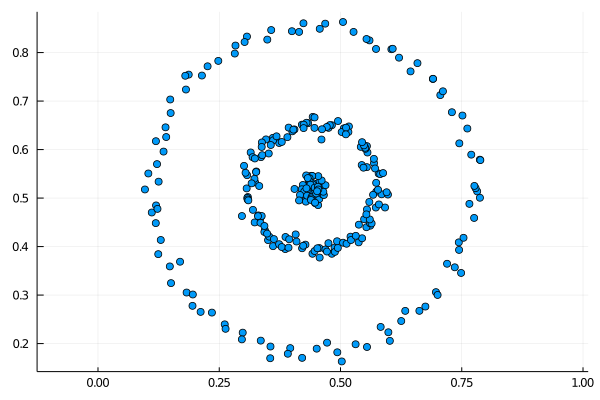

In [27]:
file = matread("Data2.mat");
X = file["data"];

# Visualize the first two dimension of the data
scatter(X[:,1], X[:,2], aspect_ratio=:equal, leg=false)

## 2. Define a distance matrix $E$

Let $E$ be the square root of the Euclidean distance matrix ([EDM](https://en.wikipedia.org/wiki/Euclidean_distance_matrix)) with entries 

$$ E_{ij}=\| x_{i}-x_{j}\|_2 $$

In [28]:
# input: X - data points
# output: E - distance matrix
#
function get_E(X)
    n = size(X,1); # number of points
    E = zeros(n,n); # the diagonal entries are 0
    
    for ii=1:n
        for jj=ii+1:n
            E[ii,jj] = norm(X[ii,:] - X[jj,:]);
            E[jj,ii] = E[ii,jj];
        end
    end
    
    return E;
end

get_E (generic function with 1 method)

In [29]:
# get the distance matrix D
E = get_E(X);

## 3. Define a kernel matrix $K$

Let $K$ be a kernel matrix with entries $ K_{ij}=k(x_{i},x_{j}) $, where $k$ is the Guassian kernel
$$ k(x,y) = e^{-\frac{\lVert x-y \rVert^2}{\sigma_i\sigma_j}}, $$
and $\sigma_i$ is a $7$th smallest value in the neighbor of a given point.

In [30]:
# evaluate sigma
E_sort = sort(E, dims=2);

k = 7;
sigma_loc = E_sort[:, k+1];

In [31]:
# input 1: E - distance matrix
# input 2: sigma - constant
#
# output: K - kernal matrix
#
function get_K(E, sigma_loc)
    n = size(E,1);
    K = ones(n,n);
    
    for ii = 1:n
        for jj = ii+1:n
            K[ii,jj] = exp(-E[ii,jj]^2/(sigma_loc[ii]*sigma_loc[jj]));
            K[jj,ii] = K[ii,jj]
        end
    end
    
    return K;
end

get_K (generic function with 1 method)

In [32]:
# get the kernal matrix K
K = get_K(E, sigma_loc);

## 4. Construct a matrix $Q$ that related to diffusion matrix

Diffusion matrix, 
$$P=D^{-1}K,$$
where $D_{ii} = \sum^n_{j=1} K_{ij}$, is a matrix that describe the connectivity between two data points, which can be consider as the probability of jumping from one point to another in one step of random walk. 
Consider a matrix $Q$, 
$$ Q=D^{-\frac{1}{2}}KD^{-\frac{1}{2}},$$
it can be shown that the eigenvalues of $P$ and $Q$ are exactly the same, while the eigenvectors of $P$ are 
$$ v = D^{-1/2}v_Q,$$
where $v_Q$'s are the eigenvectors of $Q$.

In [33]:
# input: K - kernal matrix
#
# output 1: Q
# output 2: d_sq - sqrt{D}
#
function get_Q(K)
    n = size(K,1);
    Q = zeros(n,n);
    d_sq = zeros(n);
    
    # d_sq = sqrt{D}
    for ii = 1:n
        d_sq[ii] = sqrt(sum(K[ii,:]));
    end
    
    # get components of Q
    for ii = 1:n
        for jj = 1:n
            Q[ii,jj] = K[ii,jj]/(d_sq[ii]*d_sq[jj]);
        end
    end
    
    return Q, d_sq;
end

get_Q (generic function with 1 method)

In [34]:
# get Q and d_sq
Q, d_sq = get_Q(K);

## 5. Find eigenvectors and eigenvalues of the diffusion matrix

As we mention earlier,
>the eigenvalues of $P$ and $Q$ are exactly the same, while the eigenvectors of $P$ are 
$$ v = D^{-1/2}v_Q,$$ where $v_Q$'s are the eigenvectors of $Q$.

In [35]:
# input 1: Q
# input 2: d_sq - sqrt{D}
#
# output 1: v - eigenvectors
# output 2: s - eigenvalues
#
function get_eig(Q, d_sq, c)
    
    n = size(Q, 1);
    
    S, V = eigs(Q, nev = c+1, which=:LM);

    for ii = 1 : n
        V[ii,:] = V[ii,:]/d_sq[ii];
    end
    
    return V, S;
end

get_eig (generic function with 1 method)

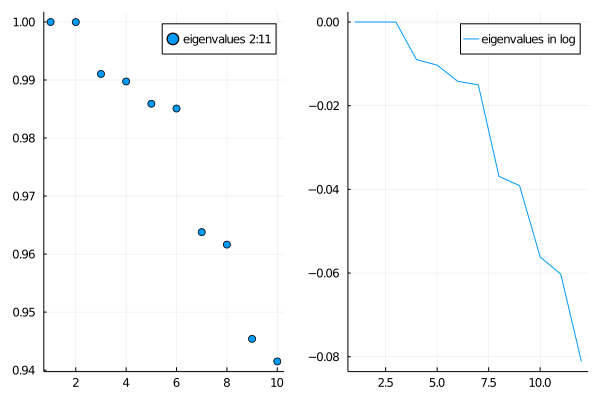

In [36]:
v, s = get_eig(Q , d_sq, 11);
p1 = scatter(s[2:11], label="eigenvalues 2:11");
p2 = plot(log.(s), label="eigenvalues in log");
plot(p1, p2, layout=2)

## 6. Define a diffusion map 

Let $Y$ be a diffusion map, which map corrdinates between data and diffusion space, with its column
$$Y_i=
\begin{bmatrix}
p_t(x_i,x_1) \\
p_t(x_i,x_2) \\
\vdots       \\
p_t(x_i,x_n) \\
\end{bmatrix}
= \left[ \lambda_i^t v_i \right] = P_{i}^t.$$

In [37]:
function get_Y(v, S, c)
    
    n = size(v,1);
    Y = zeros(n,c);
    
    # get components of diffusion map Y
    for ii = 1:c
        Y[:,ii] = v[:,ii+1].*S[ii+1];
    end
    
    return Y ;
end

get_Y (generic function with 1 method)

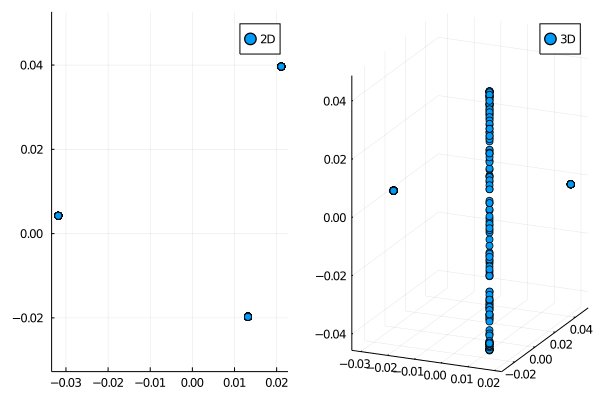

In [38]:
Y2 = get_Y(v, s, 2);
Y3 = get_Y(v, s, 3);

# print diffution map
p1 = scatter(Y2[:,1], Y2[:,2], label="2D", aspect_ratio=:equal)
p2 = scatter(Y3[:,1], Y3[:,2], Y3[:,3], label="3D", aspect_ratio=:equal)
plot(p1, p2, layout=2)

## 7. K-means Clustering

Using k-means method to get the labeling of the datas, here cluster is a manually select number of groups.

In [39]:
cluster = 3;
R2 = kmeans(transpose(Y2), cluster; maxiter=200, display=:iter);
group2 = assignments(R2); # get the assignments of points to clusters
center2 = transpose(R2.centers); # get the cluster centers

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.737344e-07
      1       1.118933e-07      -1.618411e-07 |        0
K-means converged with 1 iterations (objv = 1.1189326908555772e-7)


Visualize the results of k-mean

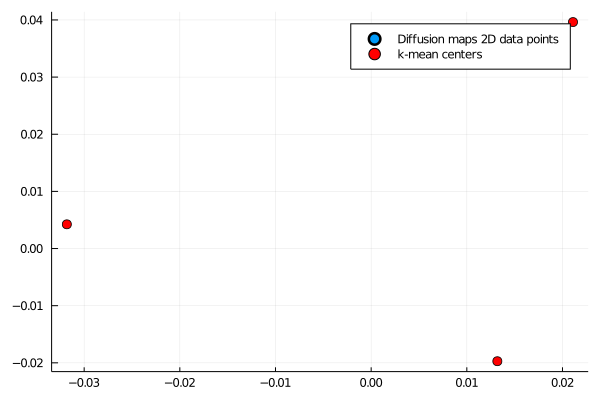

In [40]:
scatter(Y2[:,1] , Y2[:,2], markersize=:2, label="Diffusion maps 2D data points")
scatter!(center2[:,1], center2[:,2], markercolor=:red, markersize=:5, label="k-mean centers")

In [41]:
R3 = kmeans(transpose(Y3), cluster; maxiter=200, display=:iter);
group3 = assignments(R3); # get the assignments of points to clusters
center3 = transpose(R3.centers); # get the cluster centers

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.884198e-01
      1       1.780205e-01      -1.103993e-01 |        2
      2       1.779626e-01      -5.794682e-05 |        2
      3       1.779381e-01      -2.447191e-05 |        0
      4       1.779381e-01       0.000000e+00 |        0
K-means converged with 4 iterations (objv = 0.17793811347326877)


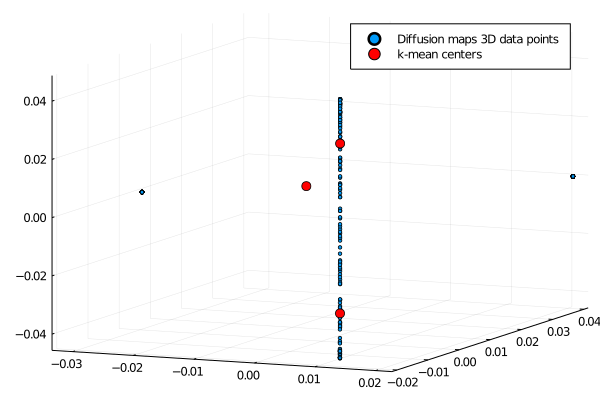

In [42]:
scatter(Y3[:,1], Y3[:,2], Y3[:,3], markersize=:2, label="Diffusion maps 3D data points")
scatter!(center3[:,1], center3[:,2], center3[:,3], markercolor=:red, markersize=:5, label="k-mean centers")

## 8. Show the result

visualize the results of clustering

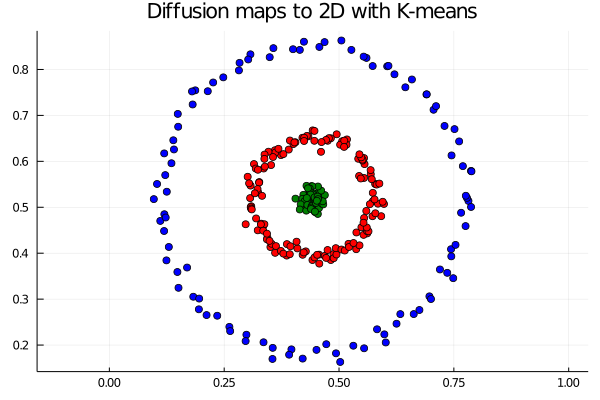

In [43]:
# select the color
dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "orange" , 5 => "cyan" , 6 => "brown" , 7 => "black");
color_group2 = Array{String}(undef, size(group2, 1));
for ii = 1 : size(group2, 1)
    color_group2[ii] = dict[group2[ii]];
end

# print
scatter(X[:,1] , X[:,2], c = color_group2, leg=false, aspect_ratio=:equal, title = "Diffusion maps to 2D with K-means")

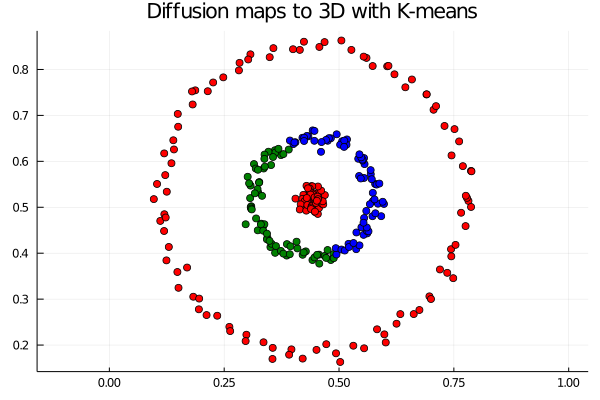

In [44]:
color_group3 = Array{String}(undef, size(group3, 1));
for ii = 1 : size(group3, 1)
    color_group3[ii] = dict[group3[ii]];
end

# print
scatter(X[:,1] , X[:,2], c = color_group3, leg=false, aspect_ratio=:equal, title = "Diffusion maps to 3D with K-means")